<h1><center><font color=red>**Rotten Sentiment with Tomatoes**</font></center></h1>
<h2><center>**Sentiment Analysis of Movie Reviews from Rotten Tomatoes**</center></h2>
<h3><center>General Assembly Data Science Immersive Project Five</center></h3> 
<h4><center>Data and Description at https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews</center></h4>

In [1]:
# Standard Imports

import numpy as np
import pandas as pd

# NLP Imports
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

# Metrics
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Different sklearn Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import svm

# Neural Network Models
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

# Graph Imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Reading in the data sets:
- Train: The training data set provided by Kaggle
- Test: The test set which is similar to the train set but missing the sentiment column to be solved.
- Sample Submission File: Provided by Kaggle to frame submission file for upload and evaluation.

In [2]:
train = pd.read_csv('./movie_data/train.tsv',sep='\t')
test = pd.read_csv('./movie_data/test.tsv',sep='\t')

sample = pd.read_csv('./movie_data/sampleSubmission.csv')

In [3]:
#train.head()
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


### Default Function that determines number of unique values, nulls, data types, etc.
- Kaggle data sets are generally pretty clean
- No missing values seen, and no issues with data types
- Only pre-processing will be to assign numeric values to Sentiment column

In [4]:
def dfcheck(data):

    #result dataframe
    df = pd.DataFrame()
    #list the colums
    df['columns'] = data.columns.tolist()
    #list the datatypes
    df['datatype'] = data.dtypes.tolist()
    # count of observations
    df['count'] = data.count().tolist()
    # count of unique values
    df['unique'] = [len(data[c].unique()) for c in data]
    #list null counts per column
    df['nulls'] = data.isnull().sum().tolist()
    df['%_null'] = df['nulls'] / df['count']
    df = df.drop('count',axis=1)
    #compile list of outliers for numeric columns
    df['outliers'] = [data[c][data[c] > data[c].mean() + (4 * data[c].std())].count() 
                if data[c].dtype == 'int64' 
                or data[c].dtype == 'float64' 
                else None for c in data]
    #returns a summary df
    return df

In [5]:
dfcheck(train)

,columns,datatype,unique,nulls,%_null,outliers
0,PhraseId,int64,156060,0,0.0,0.0
1,SentenceId,int64,8529,0,0.0,0.0
2,Phrase,object,156060,0,0.0,NaN
3,Sentiment,int64,5,0,0.0,0.0


### Following cell takes every categorical numeric value (provided by Kaggle) and assigns their meaning:
- Negative
- Neutral
- Somewhat Negative
- Somewhat Positive
- Positive

In [6]:
Sentiment_words=[]
for row in train.Sentiment:
    if row ==0:
        Sentiment_words.append('negative')
    elif row == 1:
        Sentiment_words.append('somewhat negative')
    elif row == 2:
        Sentiment_words.append('neutral')
    elif row == 3:
        Sentiment_words.append('somewhat positive')
    elif row == 4:
        Sentiment_words.append('positive')
    else:
        Sentiment_words.append('Failed')
train['Sentiment_words'] = Sentiment_words

In [7]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_words
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


### Breakout each category to determine how many of each phrase correponds to sentiment.

In [8]:
sentiment_count = pd.value_counts(train['Sentiment_words'].values)

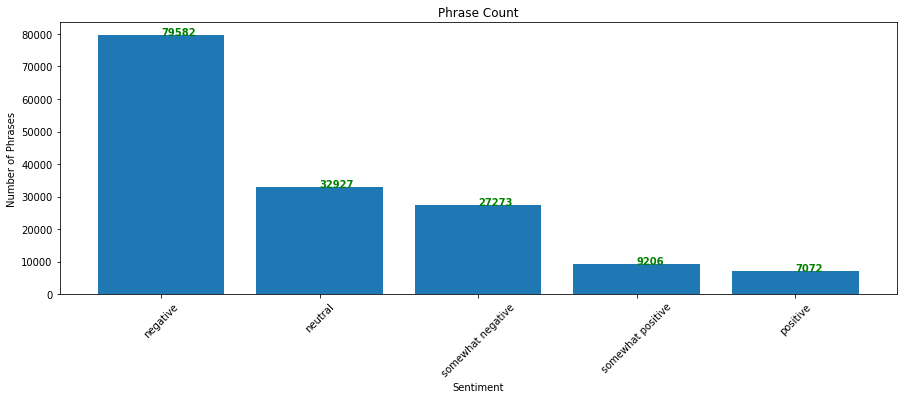

In [9]:
Index = [1,2,3,4,5]
plt.figure(figsize=(15,5))
plt.bar(Index, sentiment_count, color = 'blue')
plt.xticks(Index,['negative','neutral','somewhat negative','somewhat positive','positive'],rotation=45)
plt.ylabel('Number of Phrases')
plt.xlabel('Sentiment')
plt.title('Phrase Count')
plt.bar(Index, sentiment_count)
for a,b in zip(Index, sentiment_count):
    plt.text(a, b, str(b) ,color='green', fontweight='bold')

In [10]:
# Baseline accuracy is higher class divided by total.
print('The Baseline Accuracy is', \
      round(train['Sentiment_words'].value_counts().max() / train['Sentiment_words'].value_counts().sum(), 2))

The Baseline Accuracy is 0.51


### The following function will clean the phrases in the Phrase column eliminating "English" stop words and using the WordNet Lemmatizer in NLTK to group together inflections of a word for easier analysis.  With large data sets like the train set, running this function will take several minutes (8-18 depending on which computer I have run the cell)

In [11]:
def review_to_words(org_review): 
    review = org_review
    review = re.sub('[^a-zA-Z]', ' ',review)
    review = review.lower()
    review = review.split()
    lemmatizer = WordNetLemmatizer()
    review = [lemmatizer.lemmatize(w) for w in review if not w in set(stopwords.words('english'))]
    return (' '.join(review))

In [12]:
%%time

corpus= []
for i in range(0, train.shape[0]):
    corpus.append(review_to_words(train['Phrase'][i]))

Wall time: 17min 25s


In [13]:
%%time

corpus_test= []
for i in range(0, test.shape[0]):
    corpus_test.append(review_to_words(test['Phrase'][i]))

Wall time: 6min 13s


### The cleaning function is run on both data sets above, and then we add those clean phrases into a column in train and test dropping the original Phrase column.

In [14]:
train['Clean_Phrase']=corpus
test['Clean_Phrase']=corpus_test

In [15]:
train.drop(['Phrase'],axis=1,inplace=True)
test.drop(['Phrase'],axis=1,inplace=True)
train.head()

,PhraseId,SentenceId,Sentiment,Sentiment_words,Clean_Phrase
0,1,1,1,somewhat negative,series escapade demonstrating adage good goose...
1,2,1,2,neutral,series escapade demonstrating adage good goose
2,3,1,2,neutral,series
3,4,1,2,neutral,
4,5,1,2,neutral,series


### Filtering by positive words to determine which words in the phrase are considered positive words and sorting them by top 10 (or whatever we want).  Later applied this to all the categories to create csv's for word cloud analysis on Tableau.  For future work, turn this into a loop since I repeated this step four times after this.

In [16]:
positive=train[train['Sentiment_words']==('positive')]

words = ' '.join(positive['Clean_Phrase'])
split_word = " ".join([word for word in words.split()])

split_wordlist = split_word.split()

df = pd.DataFrame(np.array(split_wordlist))
df.to_csv('positive.csv', index=False)

In [17]:
negative=train[train['Sentiment_words']==('negative')]

negative_words = ' '.join(negative['Clean_Phrase'])
negative_split_word = " ".join([word for word in negative_words.split()])

negative_split_wordlist = negative_split_word.split()

df = pd.DataFrame(np.array(negative_split_wordlist))
df.to_csv('negative.csv', index=False)

In [18]:
neutral=train[train['Sentiment_words']==('neutral')]

neutral_words = ' '.join(neutral['Clean_Phrase'])
neutral_split_word = " ".join([word for word in neutral_words.split()])

neutral_split_wordlist = neutral_split_word.split()

df = pd.DataFrame(np.array(neutral_split_wordlist))
df.to_csv('neutral.csv', index=False)

In [19]:
pos=positive['Clean_Phrase']

cvr = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000)

pos_words = cvr.fit_transform(pos)

pos_words = pos_words.toarray()

pos= cvr.get_feature_names()

#Add up all the positive words
dist = np.sum(pos_words, axis=0)


In [20]:
positive_new = pd.DataFrame(dist)

positive_new.columns=['word_count']

positive_new['word'] = pd.Series(pos, index=positive_new.index)

positive_new.head()

,word_count,word
0,20,ability
1,32,able
2,9,absolute
3,24,absolutely
4,18,absorbing


In [21]:
positive_new1=positive_new[['word','word_count']]

sorted_positive_new1 = positive_new1.sort_values(['word_count'], ascending=False)

sorted_positive_new1.head(10)

,word,word_count
652,film,1104
1149,movie,757
1223,one,517
1280,performance,472
161,best,394
715,funny,347
760,good,339
1933,well,317
1672,story,280
1990,year,275


### Getting data ready for model.  Using max features of 2000 due to memory errors on my laptop.  Unfortunately, this will limit the efficacy of my model especially for the Kaggle competition.  Future consideration should be given to running the entire dataset in AWS or other alternate "Big Data" platforms.

In [22]:
cv = CountVectorizer(stop_words='english', strip_accents='ascii', max_features= 2000)
X = cv.fit_transform(corpus).toarray()  #  was x__train
test_X = cv.fit_transform(corpus_test).toarray() # was x__test
y = train.iloc[:, 2].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.40, random_state = 0)

### Multinomial Naive Bayes Model

In [24]:
%%time

pipeline1 = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
]) 

pipeline1.fit(X_train, y_train)


Wall time: 58.9 s
Parser   : 142 ms


In [25]:
y_pred = pipeline1.predict(X_test)
y_real_pred = pipeline1.predict(test_X)

In [26]:
print(classification_report(y_test, 
                    y_pred,
                    labels=pipeline1.classes_,
                    target_names = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']))


print("Accuracy:" + str(round(pipeline1.score(X_test, y_test), 3)))

                   precision    recall  f1-score   support

         Negative       0.66      0.03      0.05      2931
Somewhat Negative       0.49      0.13      0.21     10824
          Neutral       0.58      0.94      0.72     31864
Somewhat Positive       0.52      0.27      0.35     13068
         Positive       0.66      0.05      0.10      3737

      avg / total       0.56      0.57      0.48     62424

Accuracy:0.566


In [27]:
confusion_matrix(y_test, 
                 y_pred,
                 labels=[0, 1, 2, 3, 4]
            )

array([[   82,   773,  2001,    75,     0],
       [   30,  1457,  8998,   337,     2],
       [   10,   590, 30094,  1154,    16],
       [    2,   113,  9387,  3484,    82],
       [    0,    15,  1829,  1698,   195]], dtype=int64)

### Bernoulli Naive Bayes Model

In [28]:
%%time

pipeline2 = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', BernoulliNB())
]) 

pipeline2.fit(X_train, y_train)

Wall time: 24.7 s


In [29]:
y_pred = pipeline2.predict(X_test)
y_real_pred = pipeline2.predict(test_X)

In [30]:
print(classification_report(y_test, 
                    y_pred,
                    labels=pipeline2.classes_,
                    target_names = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']))


print("Accuracy:" + str(round(pipeline2.score(X_test, y_test), 3)))

                   precision    recall  f1-score   support

         Negative       0.39      0.21      0.28      2931
Somewhat Negative       0.46      0.26      0.33     10824
          Neutral       0.64      0.87      0.74     31864
Somewhat Positive       0.50      0.35      0.41     13068
         Positive       0.46      0.24      0.32      3737

      avg / total       0.55      0.59      0.55     62424

Accuracy:0.587


In [31]:
confusion_matrix(y_test, 
                 y_pred,
                 labels=[0, 1, 2, 3, 4]
            )

array([[  627,   946,  1153,   175,    30],
       [  586,  2818,  6491,   818,   111],
       [  244,  1685, 27682,  2045,   208],
       [  127,   586,  7010,  4631,   714],
       [   37,   106,  1054,  1642,   898]], dtype=int64)

### Trying out Random Forest Classifier with features run on a different computer as optimal.

In [32]:
%%time

pipeline3 = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators = 11, min_samples_leaf = 1, max_features = 'log2',
                                  criterion = 'entropy', bootstrap = False))
]) 

pipeline3.fit(X_train, y_train)

Wall time: 5min 38s
Parser   : 190 ms


In [33]:
y_pred = pipeline3.predict(X_test)
y_real_pred = pipeline3.predict(test_X)

In [34]:
print(classification_report(y_test, 
                    y_pred,
                    labels=pipeline3.classes_,
                    target_names = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']))


print("Accuracy:" + str(round(pipeline3.score(X_test, y_test), 3)))

                   precision    recall  f1-score   support

         Negative       0.44      0.36      0.40      2931
Somewhat Negative       0.49      0.39      0.43     10824
          Neutral       0.68      0.82      0.74     31864
Somewhat Positive       0.54      0.43      0.48     13068
         Positive       0.50      0.33      0.40      3737

      avg / total       0.60      0.61      0.60     62424

Accuracy:0.614


In [35]:
confusion_matrix(y_test, 
                 y_pred,
                 labels=[0, 1, 2, 3, 4]
            )

array([[ 1066,  1078,   706,    71,    10],
       [  999,  4183,  5209,   394,    39],
       [  322,  2683, 26213,  2474,   172],
       [   50,   464,  5939,  5626,   989],
       [   10,    63,   649,  1787,  1228]], dtype=int64)

### Extra Trees Classifier

In [36]:
%%time

pipeline6 = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', ExtraTreesClassifier())
]) 

pipeline6.fit(X_train, y_train)

Wall time: 3min 25s


In [37]:
y_pred = pipeline6.predict(X_test)
y_real_pred = pipeline6.predict(test_X)

In [38]:
print(classification_report(y_test, 
                    y_pred,
                    labels=pipeline6.classes_,
                    target_names = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']))


print("Accuracy:" + str(round(pipeline6.score(X_test, y_test), 3)))

                   precision    recall  f1-score   support

         Negative       0.43      0.35      0.39      2931
Somewhat Negative       0.49      0.38      0.43     10824
          Neutral       0.67      0.83      0.74     31864
Somewhat Positive       0.54      0.43      0.48     13068
         Positive       0.50      0.32      0.39      3737

      avg / total       0.59      0.61      0.60     62424

Accuracy:0.613


In [39]:
confusion_matrix(y_test, 
                 y_pred,
                 labels=[0, 1, 2, 3, 4]
            )

array([[ 1033,  1064,   750,    73,    11],
       [ 1002,  4103,  5272,   402,    45],
       [  314,  2662, 26296,  2424,   168],
       [   59,   441,  5987,  5607,   974],
       [    8,    49,   680,  1788,  1212]], dtype=int64)

### Bagging Classifier

In [40]:
%%time

pipeline7 = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', BaggingClassifier())
]) 

pipeline7.fit(X_train, y_train)

Wall time: 8min 19s


In [41]:
y_pred = pipeline7.predict(X_test)
y_real_pred = pipeline7.predict(test_X)

In [42]:
print(classification_report(y_test, 
                    y_pred,
                    labels=pipeline7.classes_,
                    target_names = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']))


print("Accuracy:" + str(round(pipeline7.score(X_test, y_test), 3)))

                   precision    recall  f1-score   support

         Negative       0.45      0.30      0.36      2931
Somewhat Negative       0.48      0.35      0.41     10824
          Neutral       0.67      0.82      0.74     31864
Somewhat Positive       0.52      0.43      0.47     13068
         Positive       0.46      0.32      0.38      3737

      avg / total       0.58      0.61      0.59     62424

Accuracy:0.605


In [43]:
confusion_matrix(y_test, 
                 y_pred,
                 labels=[0, 1, 2, 3, 4]
            )

array([[  869,  1122,   785,   139,    16],
       [  779,  3842,  5530,   616,    57],
       [  215,  2435, 26222,  2768,   224],
       [   44,   487,  5801,  5653,  1083],
       [    9,   108,   650,  1771,  1199]], dtype=int64)

### Trying out Logistic Regression GridSearch which finishes in a reasonable amount of time

In [44]:
%%time

pipeline4 = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(penalty = 'l1', C = 10))
]) 

pipeline4.fit(X_train, y_train)

Wall time: 44.2 s


In [45]:
y_pred = pipeline4.predict(X_test)
y_real_pred = pipeline4.predict(test_X)

In [46]:
print(classification_report(y_test, 
                    y_pred,
                    labels=pipeline4.classes_,
                    target_names = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']))


print("Accuracy:" + str(round(pipeline4.score(X_test, y_test), 3)))

                   precision    recall  f1-score   support

         Negative       0.49      0.17      0.25      2931
Somewhat Negative       0.47      0.27      0.34     10824
          Neutral       0.64      0.87      0.74     31864
Somewhat Positive       0.51      0.41      0.45     13068
         Positive       0.54      0.24      0.33      3737

      avg / total       0.57      0.60      0.56     62424

Accuracy:0.6


In [47]:
confusion_matrix(y_test, 
                 y_pred,
                 labels=[0, 1, 2, 3, 4]
            )

array([[  494,  1108,  1117,   194,    18],
       [  365,  2878,  6696,   845,    40],
       [  108,  1534, 27830,  2267,   125],
       [   28,   465,  6635,  5353,   587],
       [    4,    81,   903,  1849,   900]], dtype=int64)

<h1><center>Appendix</center></h1>
### Gridsearch Parameters for Random Forest and K-Nearest Neighbors

In [ ]:
params = {
    'n_estimators' : [1, 3, 5, 7, 9, 11],
    'min_samples_leaf' : [1, 3, 5, 7, 9],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'log2'],
    'bootstrap': [True, False]
}

GridSearchCV(
    RandomForestClassifier(),
    params
)

In [ ]:
random_forest = GridSearchCV(
    RandomForestClassifier(),
    params
).fit(X_train, y_train)

In [ ]:
random_forest.score(X_test, y_test)

In [ ]:
knn =GridSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors':[1, 3, 5, 7, 9],
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']

    }
)

In [ ]:
%%time

knn.fit(X_train, y_train)

In [ ]:
knn.score(X_test, y_test)

### Kaggle Submission

In [ ]:
predictions = pipeline4.predict(test_X)  # for submission to Kaggle

test['Sentiment'] = predictions

test[['PhraseId', 'Sentiment']].to_csv('logistic.csv', index=False)